## Modules

In [1]:
#MODULES
#Python and OS
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from collections import Counter

#RadarScenes
from radar_scenes.sequence import Sequence
from radar_scenes.labels import Label, ClassificationLabel

#Dataset
import sys
BASE_DIR = os.path.dirname(os.path.abspath(os.getcwd()))
sys.path.append(BASE_DIR)

from PointNet.pnet_dataset import PNETDataset
from torch.utils.data import DataLoader, Subset


#scikit dbscan
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

### Retrieveing RadarScene Dataset

In [2]:
#mpl.rcParams["figure.figsize"]=15,15
dataset_path= "/home/s0001519/RadarProj/RadarScenes/train"
snippet_path="/home/s0001519/RadarProj/venv/zenseact_repo/thesisdlradardetection/static/train.txt"
n_points = 3097
dataset = PNETDataset(dataset_path, snippet_path, n_points)

# Get the sequence from where the snippet belongs to:
test_index_start = 25 #25-good test with trhe 250 train dataset (change in test_radar...)
#getting a subset (in this case, one snippet to plot)  
subset = True    
if (subset):                   
    numel_train_subset = 1  
    list_t = list(range(test_index_start, (numel_train_subset + test_index_start), 1))
    dataset = Subset(dataset, list_t) 

generator = DataLoader(dataset, batch_size=None, shuffle=False, 
                       pin_memory=True,num_workers=10, drop_last=False)


xyv = np.zeros((n_points,5))
true_label = np.zeros((n_points,1))
for data, label, _ in generator:
    print("Shape of training data: ", data.shape[0], ". Shape of labels: ", label.shape) 
    print("Length of data: ", len(dataset))       
    print()   
    xyv[:,0] = data[:,0].numpy() #x
    xyv[:,1] = data[:,1].numpy() #y
    xyv[:,2] = data[:,2].numpy() #vr
    xyv[:,3] = data[:,3].numpy() #vr
    xyv[:,4] = data[:,4].numpy() #vr
    true_label[:,0] = label.numpy()  #label
    break

#X = np.concatenate((x.reshape(-1,1),y.reshape(-1,1),vr.reshape(-1,1)),axis=1) #v_r added

Shape of training data:  3097 . Shape of labels:  torch.Size([3097])
Length of data:  1



### DBSCAN

Estimated number of clusters: 6
Estimated number of noise points: 3019
Silhouette Coefficient: -0.401


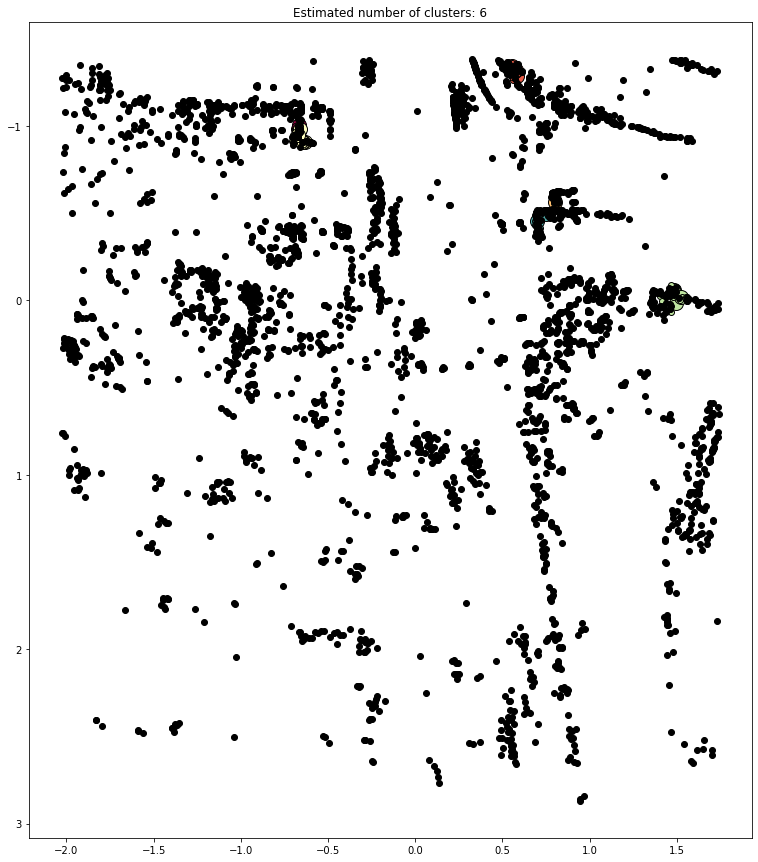

In [4]:

xyv = StandardScaler().fit_transform(xyv)

#Calculate N_min(r)
#N50 = 4
#Nr = N50 * (1 + alpha)

# Compute DBSCAN
#db = DBSCAN(eps=0.08, min_samples=9).fit(X) #with x and y
#db = DBSCAN(eps=0.11, min_samples=9).fit(xyv)  #with x, y and vr
db = DBSCAN(eps=0.11, min_samples=9).fit(xyv)  #with x, y and vr

core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)
"""
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(labels_true, labels))
print(
    "Adjusted Mutual Information: %0.3f"
    % metrics.adjusted_mutual_info_score(labels_true, labels)
)
"""
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(xyv, labels))


# Plot result

mpl.rcParams["figure.figsize"]=15,15
# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = xyv[class_member_mask & core_samples_mask]
    plt.plot(
        #xy[:, 0],
        #xy[:, 1],
        xy[:, 1],
        xy[:, 0],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=14,
    )

    xy = xyv[class_member_mask & ~core_samples_mask]
    plt.plot(
        #xy[:, 0],
        #xy[:, 1],
        xy[:, 1],
        xy[:, 0],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )

plt.gca().set_aspect('equal', adjustable='box')
plt.gca().invert_yaxis()
plt.title("Estimated number of clusters: %d" % n_clusters_)
plt.show()